# Solving First Price Sealed Bid auctions using Revenue Equivalence

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
from scipy import stats
import seaborn as sns
from scipy import interpolate 

# for plots 
plt.rcParams.update({"text.usetex": True, 'font.size':14})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# ensuring this notebook generates the same answers 
np.random.seed(1337)

## A reminder: Linear interpolation

*Just to remind you how we can use a linear interpolator in Python. 

Consists of two steps: 
1. preparing the interpolator: runs precomputation and returns a function handle. Call `interpolate.interp1d`. 
2. evaluating the interpolator. 

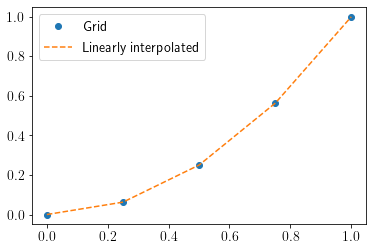

In [2]:
xx = np.linspace(0,1,5)
yy = xx ** 2 # the "unknown" function

xx_fine = np.linspace(0,1,1000) # many more points here 

# prepare interpolation function (precomputation)
f_ = interpolate.interp1d(xx,yy,kind='linear')

# evaluate 
plt.plot(xx,yy,'o', label='Grid')
plt.plot(xx_fine,f_(xx_fine), '--', label='Linearly interpolated'); 
plt.legend(loc='best'); 

# Illustrating the Revenue Equivalence Theorem 

In [3]:
N = 5
R = 100000

In [4]:
np.random.seed(1337)
v = np.random.uniform(0,1,(N,R))

In [5]:
# BNE in first-price sealed bid
b_star = lambda vi,N: (N-1)/N * vi
b = b_star(v,N)

### Continuing work 

In [6]:
idx = np.argsort(v, axis=0)
v = np.take_along_axis(v, idx, axis=0) # same as np.sort(v, axis=0), except now we retian idx 
b = np.take_along_axis(b, idx, axis=0)

ii = np.repeat(np.arange(1,N+1)[:,None], R, axis=1)
ii = np.take_along_axis(ii, idx, axis=0)

winning_player = ii[-1,:]

winner_pays_fpsb = b[-1, :] # highest bid 
winner_pays_spsb = v[-2, :] # 2nd-highest valuation

### Distribution of payments

We know from the **Revenue Equivalence Theorem** that the *average* payment should be identical. However, the distribution of payments may *look* different. That is, the variance, median, etc. of the winning payments may be different. 

Avg. payment FPSB:  0.66652 (std.dev. =  0.11)
Avg. payment SPSB:  0.66670 (std.dev. =  0.18)


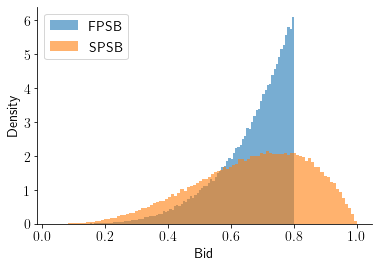

In [7]:
fig,ax = plt.subplots(); 
for x,lab in zip([winner_pays_fpsb,winner_pays_spsb], ['FPSB', 'SPSB']): 
    print(f'Avg. payment {lab}: {x.mean(): 8.5f} (std.dev. = {np.sqrt(x.var()): 5.2f})')
    ax.hist(x, density=True, alpha=0.6, label=lab, bins=100); 
ax.legend(loc='best'); ax.set_xlabel('Bid'); ax.set_ylabel('Density'); sns.despine()

Let's now plot the *winning bids* $b_{(n)}$ (i.e. the payments) against valuations, $v_{(n)}$ for FPSB and SPSB respectively. Here, we may note that 
* FPSB: there is a unique bid corresponding to each valuation, 
* SPSB: What the winner pays varies even holding fixed the winner's valuation (because it is equal to the valuation of the second-highest type). 

In [8]:
binned = stats.binned_statistic(v[-1, :], v[-2, :], statistic='mean', bins=20)
xx = binned.bin_edges
xx = [(xx[i]+xx[i+1])/2 for i in range(len(xx)-1)]
yy = binned.statistic

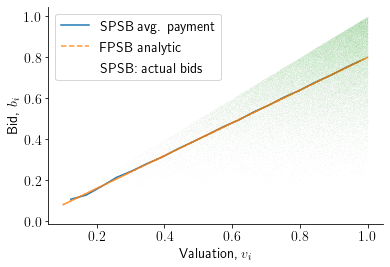

In [9]:
fig,ax = plt.subplots(); 
ax.plot(xx, yy,                        label='SPSB avg. payment'); 
ax.plot(v[-1, :], b[-1, :], '--', alpha=0.8, label='FPSB analytic'); 
ax.plot(v[-1, :], v[-2, :], 'o', alpha=0.05, markersize=.1, label='SPSB: actual bids'); 
ax.legend(loc='best'); sns.despine(); ax.set_xlabel('Valuation, $v_i$'); ax.set_ylabel('Bid, $b_i$'); 

## A quick look through pandas

This section merely shows how to set up the valuations and bids in a Pandas DataFrame, which may be easier to look at and get an overview of. 

In [10]:
mat = (v.T, b.T)
mat = np.hstack(mat)
v_ = [f'v{i+1}' for i in range(N)] # list of variable names for valuations
b_ = [f'b{i+1}' for i in range(N)] # ... for bids
dat = pd.DataFrame(mat, columns = v_ + b_)
dat.index.name = 'r'

In [11]:
dat[v_].head(5)

,v1,v2,v3,v4,v5
r,,,,,
0,0.262025,0.436078,0.667935,0.930770,0.991727
1,0.004887,0.158684,0.261774,0.334389,0.582017
2,0.081071,0.247090,0.278127,0.770553,0.845722
3,0.010873,0.045481,0.459317,0.581799,0.875999
4,0.321001,0.363505,0.607044,0.789102,0.928140


In [12]:
dat['v5'].mean()

0.8331453685178388

In [13]:
dat['v4'].mean()

0.6666970469433559

In [14]:
dat['b5'].mean()

0.6665162948142672

# Solving for the FPSB numerically using Revenue Equivalence

## Expectation of the 2nd order statistic

Our procedure is the following: 

* Input: \bar{v}: the lower truncation value, $R$: the # of draws. 
1. Draw $v_{r}$ for draws $r = 1,...,R$. 
2. Subset, choosing $\mathcal{R} \equiv \{ r \in \{1,...,R\} \vert v_{r} \le \bar{v} \}$
3. Reshape dataset to $v_{i,r}$ for $i = 1,...,N$ and $r = 1,..., \tilde{R}$. 
    * *Note:* We will have to throw away some of the very last observations to have a square matrix. Specifically, we throw away the last mod$(\vert \mathcal{R} \vert, N)$ simulated draws. 
4. For each simulation, $r \in \mathcal{R}$, find the 2nd largest value, $v_{(n-1),r}$
5. Return $\hat{\mathbb{E}}(v_{(n-1)}) = R^{-1} \sum_{r=1}^R v_{(n-1),r}$. 

In [15]:
def Ev_largest(vi, v_sim_untruncated, N, R_used_min=42): 
    '''Ev_largest: compute the expected value of maximum drawing from a truncated distribtion 
                    where v_sim_untruncated are draws from the untruncated and vi is the 
                    truncation point. 
        
        INPUTS: 
            vi: (scalar) upper truncation point 
            v_sim_untruncated: (R-length 1-dim np array) draws of v from the untruncated distribution
            N: (int) number of draws per iteration  
            R_used_min: (int, optional) assert that we have at least this many samples. (Set =0 to disable.)
            
        OUTPUTS
            Ev: (float) expected value of the largest across simulations
            R_used: (int) no. replications used to compute simulated expectation
    '''
    assert v_sim_untruncated.ndim == 1, f'Expected 1-dimensional array'
    
    # perform truncation 
    I = v_sim_untruncated <= vi
    v_sim = np.copy(v_sim_untruncated[I])

    # drop extra rows
    drop_this_many = np.mod(v_sim.size, N)
    if drop_this_many>0: 
        v_sim = v_sim[:-drop_this_many]
    
    # reshape
    R_used = int(v_sim.size / N)
    v_sim = np.reshape(v_sim, (N,R_used))
    assert R_used > R_used_min, f'Too few replications included: only {R_used}. Try increasing original R.'
    
    # find largest value 
    v_sim = np.sort(v_sim, 0) # sorts ascending ... 
    v_largest = v_sim[-1, :]  # ... so the last *row* is the maximum in columns (samples)
    
    # evaluate expectation
    Ev = np.mean(v_largest)
    
    return Ev

## Proof that it works: uniforms

The convenient feature of auctions with uniformly distributed valuations is that we can solve for the Bayesian Nash Equilibrium (BNE) analytically. Hence, we can compoare it to our analytical solution. 

In [16]:
R = 1000000
np.random.seed(1337)
v = np.random.uniform(0,1,(N,R)).flatten()

In [17]:
vgrid = np.linspace(0, 1, 10, endpoint=False)[1:]
Ev = np.empty((vgrid.size,))

for i,this_v in enumerate(vgrid): 
    Ev[i] = Ev_largest(this_v, v, N-1) # Crucially: we draw *one less* obs. per simulated sample

### Analytic vs. numerical solution

* **Analytic:** Using the exact formula for FPSB, which works because $v_i \sim IID \mathcal{U}(0,1)$. 
* **Numerical:** Using Revenue Equivalance, we compute the expectation of the 2nd order statistic conditional on the winning bid. 

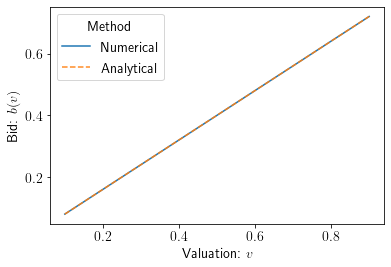

In [18]:
fig, ax = plt.subplots(); 

ax.plot(vgrid, Ev,               '-', label='Numerical'); 
ax.plot(vgrid, b_star(vgrid, N), '--', label='Analytical', alpha=0.9); 

ax.legend(loc='best', title='Method'); 
ax.set_ylabel('Bid: $b(v)$'); ax.set_xlabel('Valuation: $v$'); 

## $\chi^2$ distributed errors 

Here, it is somewhat harder to solve for the optimal bidding

In [19]:
np.random.seed(1337)
v = np.random.chisquare(df=2, size=(N*R,))

The distribution of drawn values 

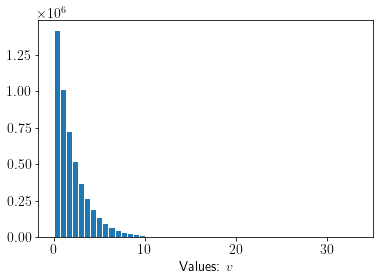

In [20]:
plt.hist(v, bins=50, edgecolor='w'); plt.xlabel('Values: $v$');  

## Solve for the BNE of the First Price Sealed Bid (FPSB) auction

### 1. set up grid

In [21]:
# for our nested function, v should be "flattened" (i.e. in vector form)
np.random.seed(1337)
v = np.random.chisquare(df=2, size=(N*R,)) 

# we want to solve for optimal bids for all values of v that a player might draw, 
# hence we create vgrid to be equi-probable over the draws of v 
ngrid = 100
pcts = np.linspace(0, 100, ngrid, endpoint=False)[1:]
vgrid = np.percentile(v, q=pcts)

This plot shows the grid over which we will evaluate our numerical solution. We will then be interpolating linearly between those dots should we require to when we later *evaluate* our solution

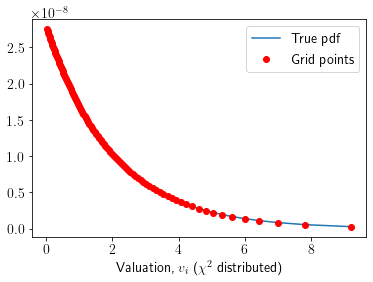

In [22]:
yy = stats.distributions.chi2.pdf(vgrid + [v.max()], 2)
plt.plot(vgrid, yy, '-', label='True pdf'); 
plt.plot(vgrid, yy, 'or', label='Grid points'); 
plt.legend(loc='best'); plt.xlabel('Valuation, $v_i$ ($\chi^2$ distributed)'); 

In [23]:
# loop 
Ev = np.empty(vgrid.shape)
for i,this_v in enumerate(vgrid): 
    Ev[i] = Ev_largest(this_v, v, N-1)
    
# by construction / assumption, the lowest-valued bidder always pays zero
Ev    = np.insert(Ev, 0, 0.0)
vgrid = np.insert(vgrid, 0, 0)

# set up interpolation function for the solution
b_star_num = interpolate.interp1d(vgrid, Ev, fill_value='extrapolate')

Show the solution over the grid 

In [24]:
pcts = np.linspace(0, 100, 1000, endpoint=False)
vgrid_fine = np.percentile(v, q=pcts)

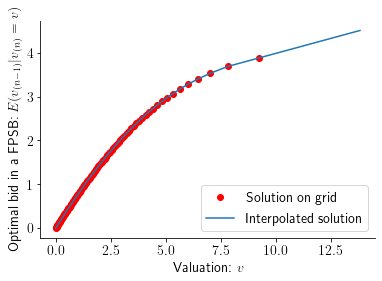

In [25]:
fig,ax = plt.subplots(); 
ax.plot(vgrid, Ev, 'or', label='Solution on grid'); 
ax.plot(vgrid_fine, b_star_num(vgrid_fine), '-', label='Interpolated solution')
ax.set_xlabel('Valuation: $v$'); ax.set_ylabel('Optimal bid in a FPSB: $E(v_{(n-1)} | v_{(n)} = v)$'); sns.despine(); 
ax.legend(loc='best'); 

In [26]:
v = v.reshape((N,R))

In [27]:
b = b_star_num(v)

In [28]:
idx = np.argsort(v, axis=0)
v = np.take_along_axis(v, idx, axis=0) # same as np.sort(v, axis=0), except now we retian idx 
b = np.take_along_axis(b, idx, axis=0)

ii = np.repeat(np.arange(1,N+1)[:,None], R, axis=1)
ii = np.take_along_axis(ii, idx, axis=0)

winning_player = ii[-1,:]

winner_pays_fpsb = b[-1, :] # highest bid 
winner_pays_spsb = v[-2, :] # 2nd-highest valuation

Avg. payment FPSB:  2.57286 (std.dev. =  0.84, median= 2.59)
Avg. payment SPSB:  2.56558 (std.dev. =  1.36, median= 2.32)


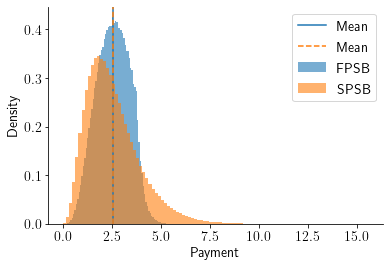

In [29]:
fig,ax = plt.subplots(); 

# plot FPSB and SPSB winner payments k
for x,lab in zip([winner_pays_fpsb,winner_pays_spsb], ['FPSB', 'SPSB']): 
    # compute avg. and std.dev. of payment
    print(f'Avg. payment {lab}: {x.mean(): 8.5f} (std.dev. = {np.sqrt(x.var()): 5.2f}, median={np.median(x): 5.2f})')
    
    # show histogram 
    ax.hist(x, density=True, alpha=0.6, label=lab, bins=100); 

# also show the average payment
ax.axvline(winner_pays_fpsb.mean(), color=colors[0], linestyle='-', label='Mean'); 
ax.axvline(winner_pays_spsb.mean(), color=colors[1], linestyle='--', label='Mean'); 

# to make nice 
ax.legend(loc='best'); ax.set_xlabel('Payment'); ax.set_ylabel('Density'); sns.despine()

## Numerical errors 

Finally, let us cover an issue that can arise sometimes due to loss of numerical precision. In fact, the problem will *always* be present when using a step-wise linear function, it simply becomes almost invisible when we choose the number and placement of grid points in a sufficiently clever way. 

Before, we used an *equiprobable* grid. Let's see what happens if we use a simple *linear* grid (using `np.linspace`). 

What happens is that the grid points are no longer placed where we need them most, so they matter a lot more. 

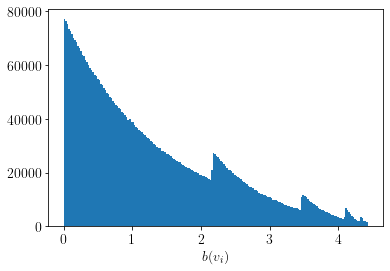

In [45]:
v = v.reshape((N*R,))

ngrid = 10
#pcts = np.linspace(0, 100, ngrid, endpoint=False)[1:]
#vgrid = np.percentile(v, q=pcts)
vgrid = np.linspace(v.min(), v.max(), ngrid+2)[1:-1]

# loop 
Ev = np.empty(vgrid.shape)
for i,this_v in enumerate(vgrid): 
    Ev[i] = Ev_largest(this_v, v, N-1)
    
# by construction / assumption, the lowest-valued bidder always pays zero
Ev    = np.insert(Ev, 0, 0.0)
vgrid = np.insert(vgrid, 0, 0)

# set up interpolation function for the solution
b_star_num = interpolate.interp1d(vgrid, Ev, fill_value='extrapolate')

# evaluate optimal bids and plot the distribution of *all* bids
bids = b_star_num(v)
plt.hist(bids, bins=200);
plt.xlabel('$b(v_i)$');

Let's zoom in around the first grid point, where the density appears to jump discontinuously: 

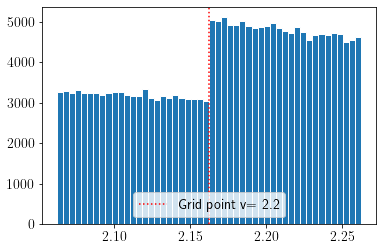

In [41]:
this_b = b_star_num(vgrid[1])
I = np.abs(bids - this_b) < 0.1
plt.hist(bids[I], bins=50, edgecolor='w'); 
plt.axvline(this_b, color='r', linestyle=':', label=f'Grid point v={this_b:5.1f}'); 
plt.legend(loc='lower center'); 

**Why does this pattern occur?** Because a *kink* in the bid function (which is piecewise linear) results in a *discontinuity* in the CDF. This is because the slope of the bidding function is constant but jumps at the grid points. Since the histogram is measuring how many observations fall in a given interval, if $b(v)$ starts to increase more slowly, then we move past that particular bin at a slower pace, trapping more observations within the bin. 

**Does it matter?** It actually does if we were to use this in practice: in equilibrium, there cannot be mass points or discontinuities in the bid distribution. Otherwise, a profitable deviation would be to take some of the mass just above (or at) the discontinuity and shift it $\varepsilon$ below the discontinuity. If $\varepsilon$ is small enough, the loss in expected utility (conditional on winning) is very small, but the gain in terms of the increase in $\Pr(win)$ is discontinuous (almost by definition: the bid CDF is discontinuous). In other words: if you are playing against someone using a piecewise linear approximation *and you know the grid point locations*, then you can exploit them. 